In [1]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

import xgboost as xgb

import imblearn
from imblearn.over_sampling import SMOTE

In [3]:
# Read in data

data = pd.read_csv('/content/drive/MyDrive/IndependentProjects/BOSS_AI_PROJECT/ND_Analytics_Challenge_Dataset.csv')

In [ ]:
# Separate data to date, time, and convert these columns (and datetime) to a datetime

# Create empty lists for date and time values
dates = []
times = []

days = []
months = []
years = []

hours = []
minutes = []
# Convert column to list
datetimes = data['datetime'].tolist()

# Iterate through all datetimes
for datetime in datetimes:
    # Strip date and time from splitting string
    date = datetime.split(' ')[0]
    time = datetime.split(' ')[1]
    # Append date and time to list
    dates.append(date)
    times.append(time)
    # Strip year, month, and day from splitting date string
    year = date.split('-')[0]
    month = date.split('-')[1]
    day = date.split('-')[2]
    # Append year, month, and day to list
    years.append(year)
    months.append(month)
    days.append(day)
    # Strip hour and minute from splitting time string
    hour = time.split(':')[0]
    minute = time.split(':')[1]
    # Append hour and minute to list
    hours.append(hour)
    minutes.append(minute)

# Set columns equal to lists
data['date'] = dates
data['time'] = times
data['year'] = years
data['month'] = months
data['day'] = days
data['hour'] = hours
data['minute'] = minutes

# Convert all three columns to datetimes
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')

data['day_of_week'] = data['datetime'].dt.day_name()

In [ ]:
# Create new experimental columns to look for distinct relationsips

data['sum_to_avg_ratio'] = data['sum_amount'] / data['avg_amount_per_user'] # Essentially number of users at a given time
data['sum_times_avg'] = data['sum_amount'] * data['avg_amount_per_user']

data = data[['datetime', 'year', 'month', 'day', 'day_of_week', 'time', 'hour', 'minute', 'sum_amount', 'avg_amount_per_user', 'sum_to_avg_ratio', 'sum_times_avg','anomaly']]

12233
41


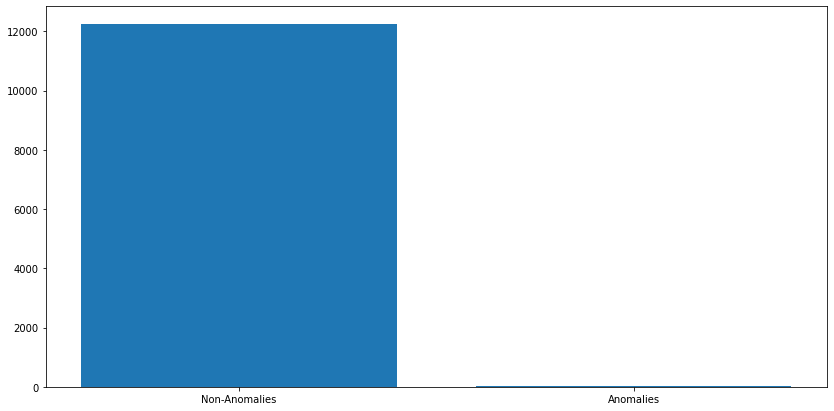

In [6]:
# Separate data into normal and anomalies for graphing purposes

normal = data[data['anomaly'] == False]
anomaly = data[data['anomaly'] == True]

print(len(normal))
print(len(anomaly))

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(['Non-Anomalies', 'Anomalies'], [len(normal), len(anomaly)])
plt.show()

In [ ]:
# Plot the relationship between columns

def plot_relationship(col1, col2, normal, anomaly):

    fig, ax = plt.subplots(figsize=(14, 7))

    plt.scatter(normal[col1], normal[col2])
    plt.scatter(anomaly[col1], anomaly[col2])

    plt.xlabel(col1, fontsize=18)
    plt.ylabel(col2, fontsize=18)
    plt.title(col2 + ' vs ' + col1, fontsize=20)

    plt.legend(['Non-Anomaly', 'Anomaly'], fontsize=18)

    ax.set_ylim(bottom=0)

    plt.show()
    print(' ')

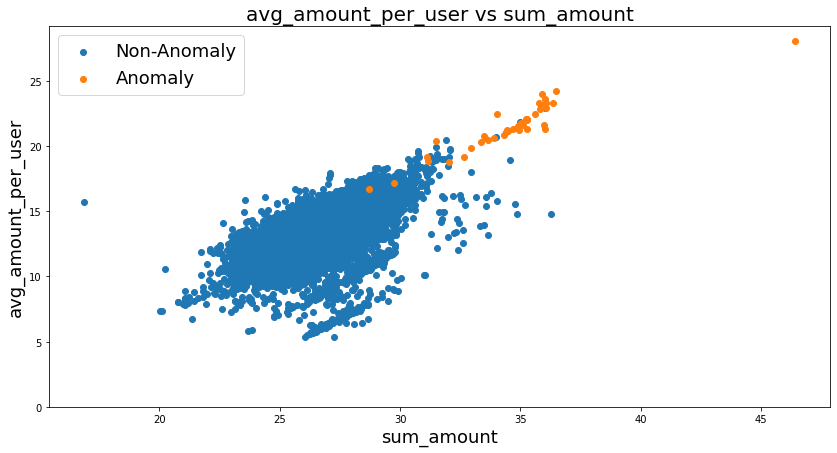

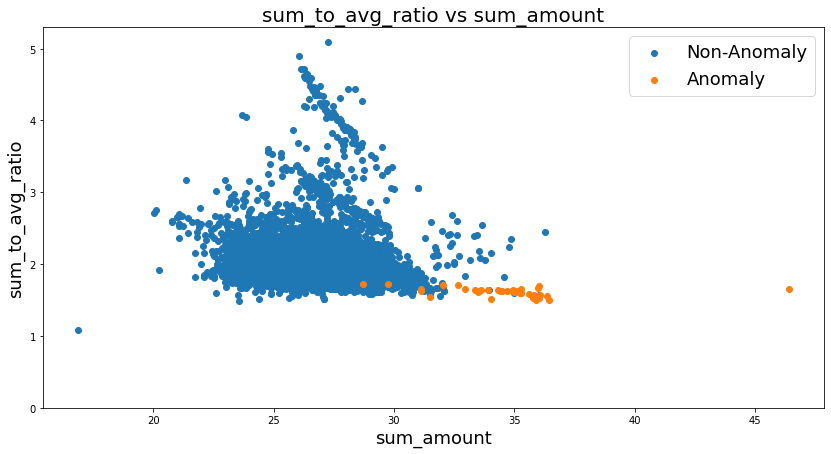

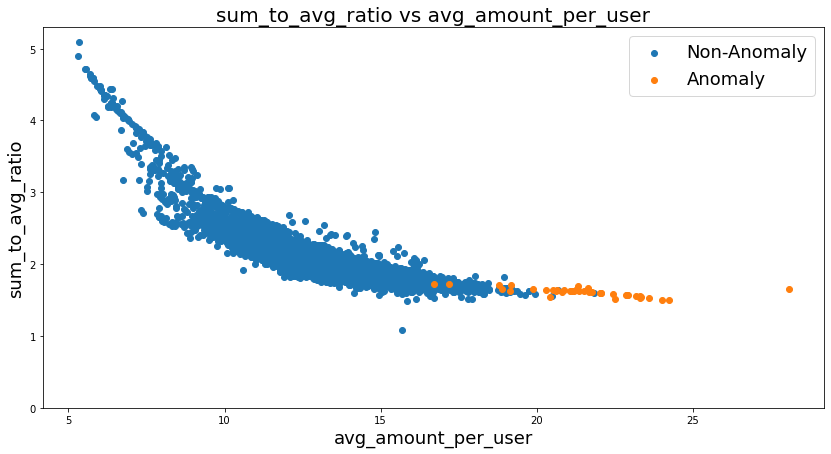

In [ ]:
original_metrics = ['sum_amount', 'avg_amount_per_user', 'sum_to_avg_ratio']

plot_relationship(original_metrics[0], original_metrics[1], normal, anomaly)
plot_relationship(original_metrics[0], original_metrics[2], normal, anomaly)
plot_relationship(original_metrics[1], original_metrics[2], normal, anomaly)


ORIGINAL METRICS:


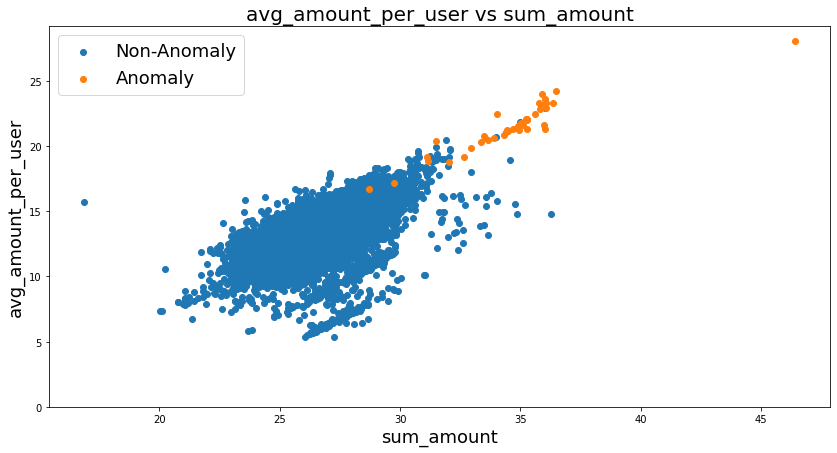

 
DERIVED METRICS:


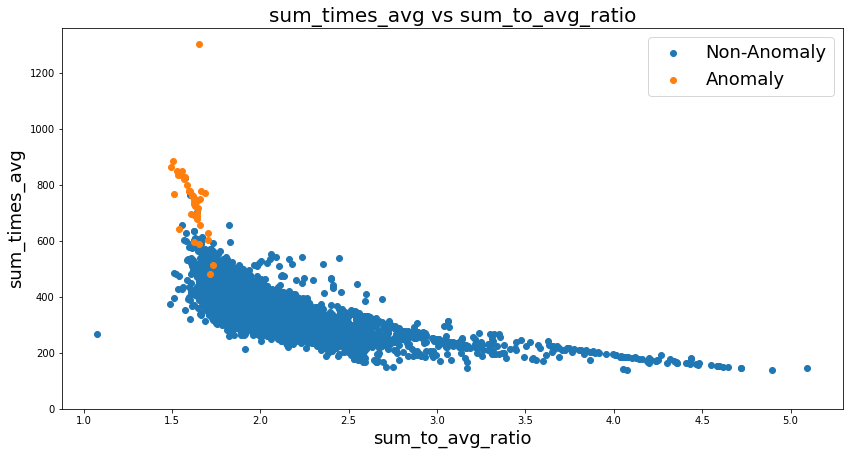

 
ALL METRICS OVER TOTAL TIME PERIOD


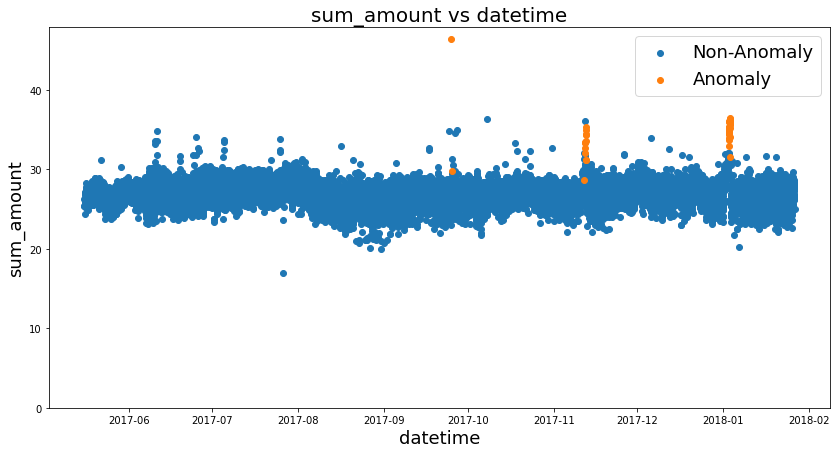

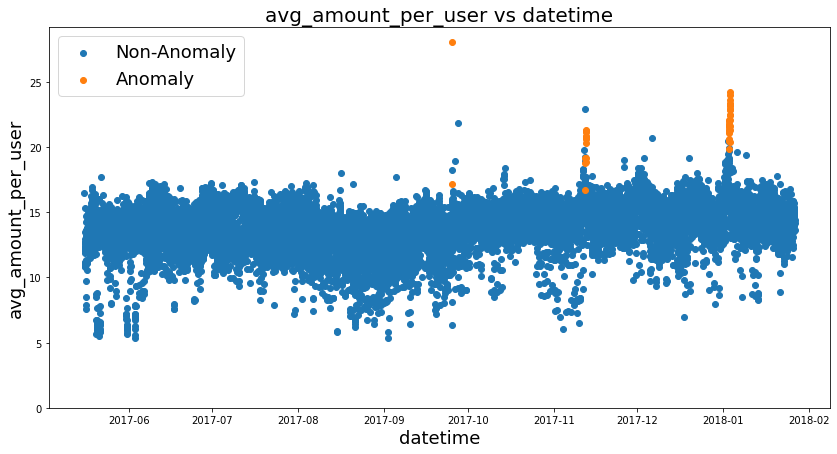

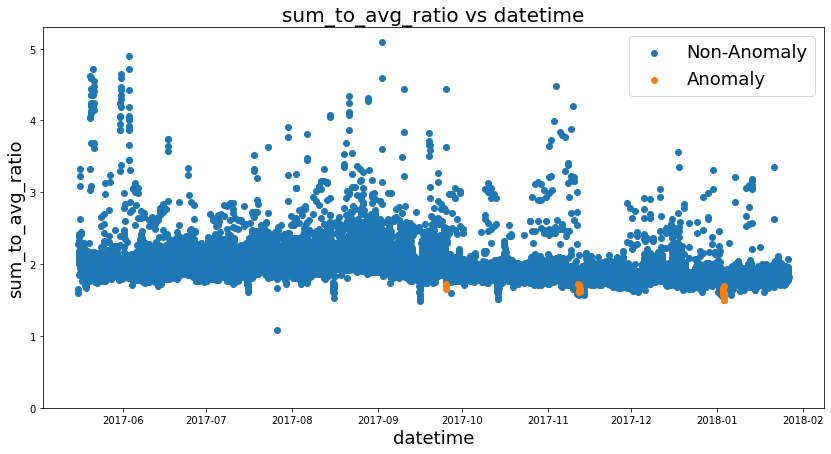

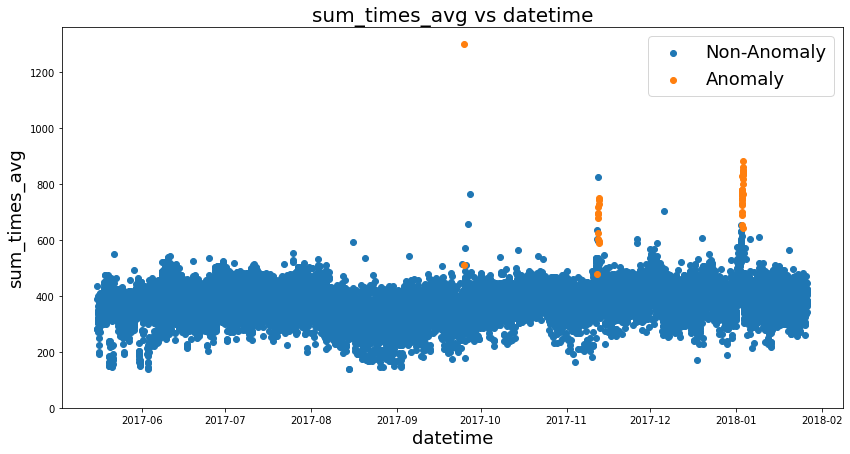

In [ ]:
original_metrics = ['sum_amount', 'avg_amount_per_user']
new_metrics = ['sum_to_avg_ratio', 'sum_times_avg']

# Plot original columns relationship
print('ORIGINAL METRICS:')
plot_relationship(original_metrics[0], original_metrics[1], normal, anomaly)
# Plot new columns relationship
print('DERIVED METRICS:')
plot_relationship(new_metrics[0], new_metrics[1], normal, anomaly)
# Plot original metrics over time
print('ALL METRICS OVER TOTAL TIME PERIOD')
for col in original_metrics:
    plot_relationship('datetime', col, normal, anomaly)
for col in new_metrics:
    plot_relationship('datetime', col, normal, anomaly)

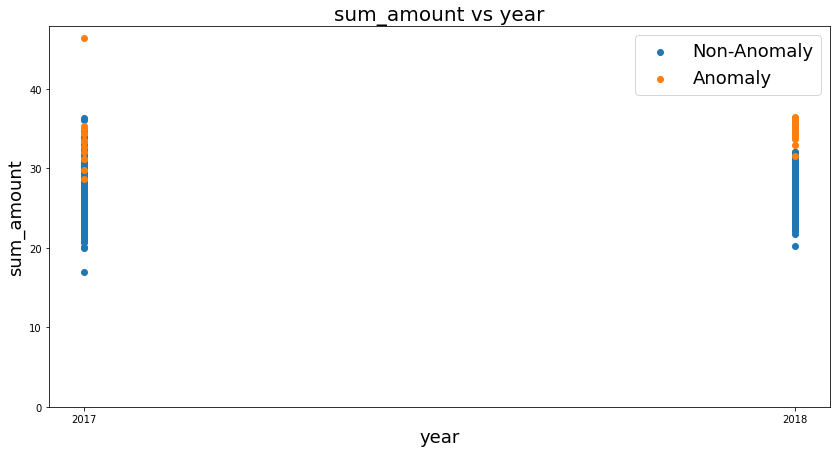

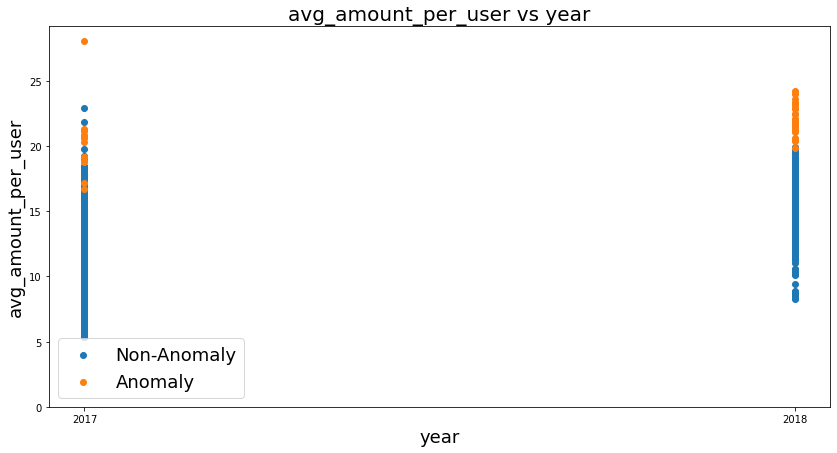

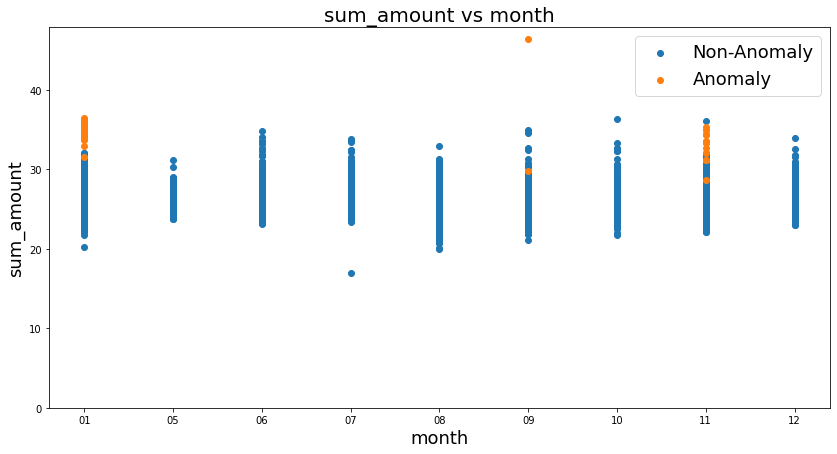

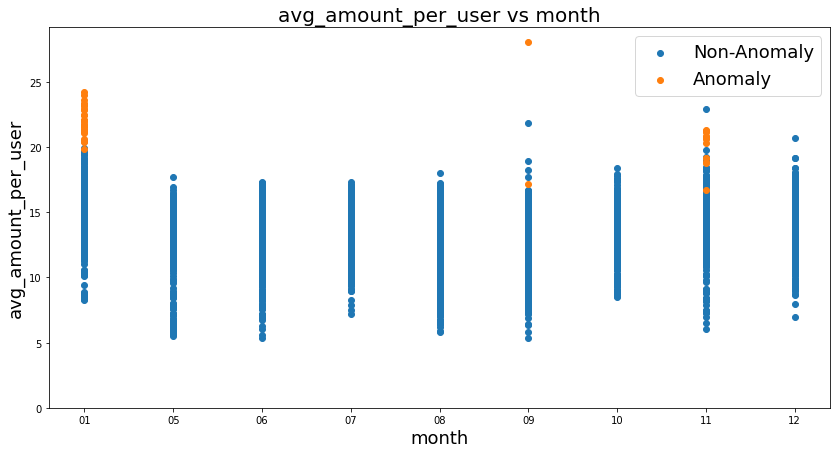

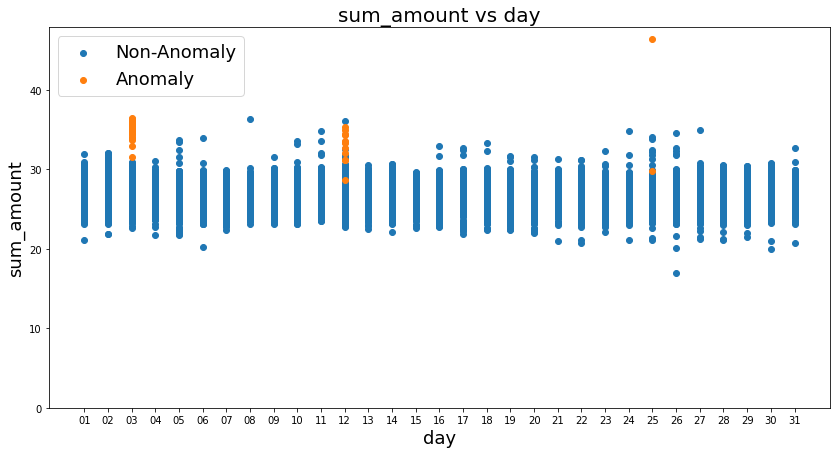

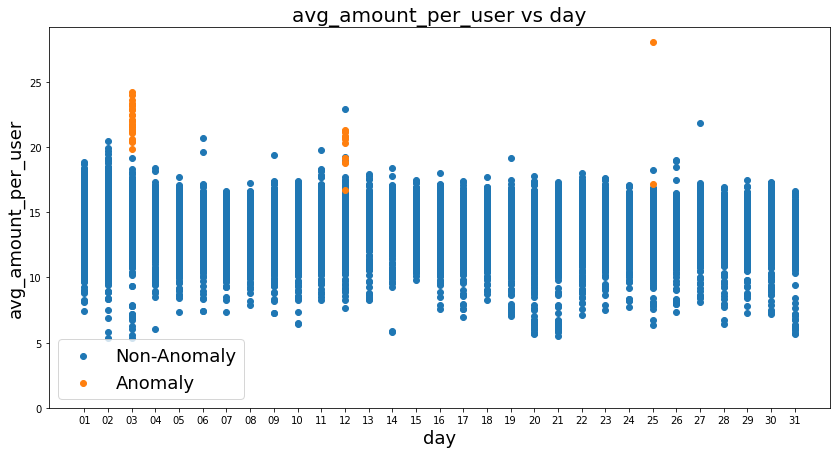

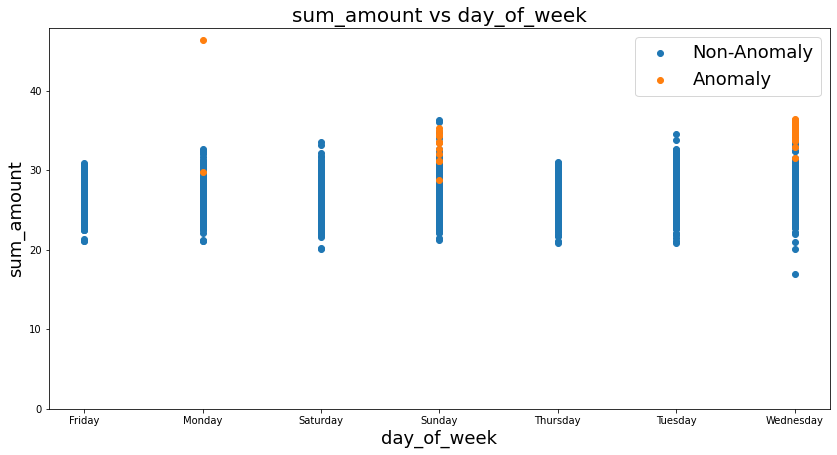

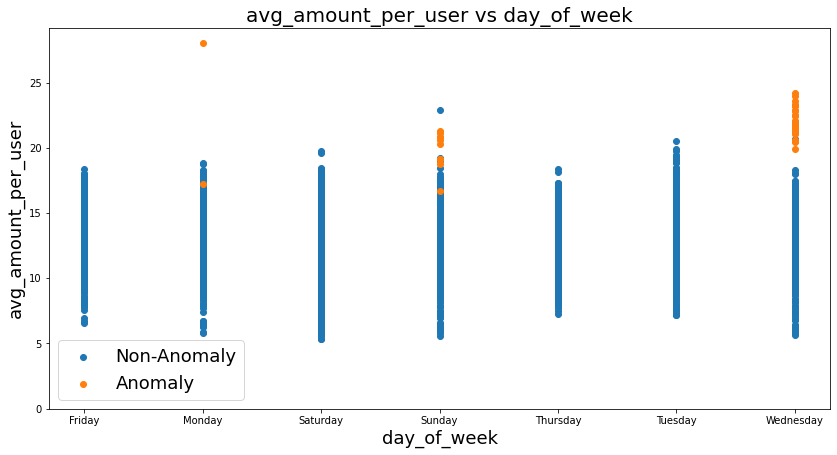

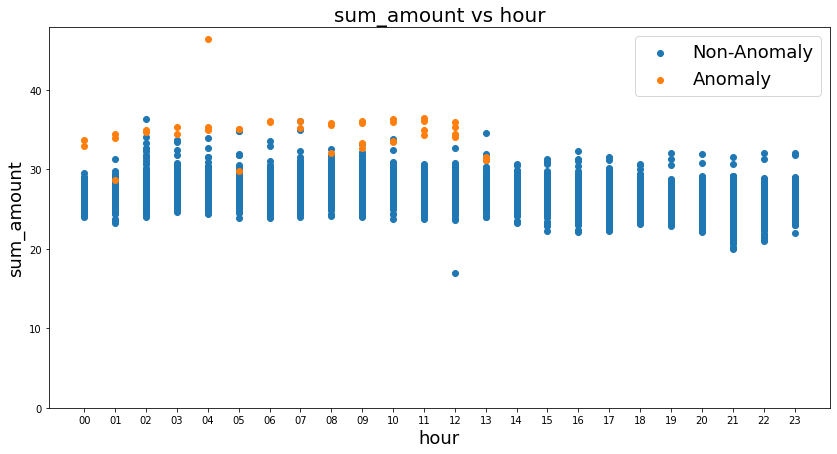

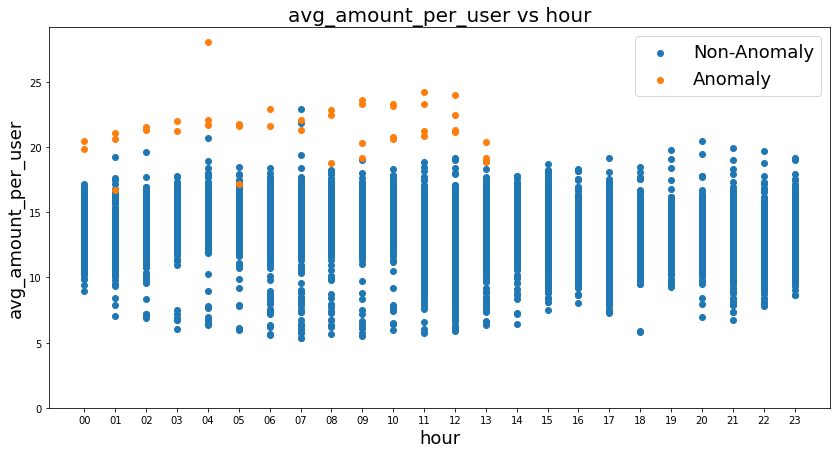

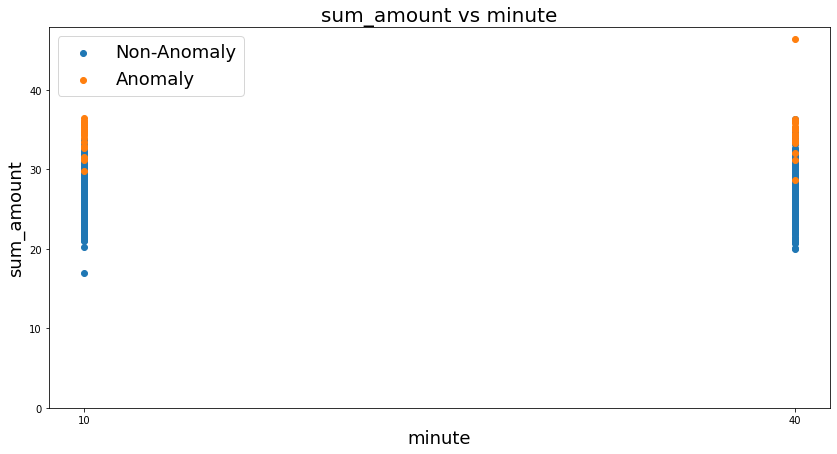

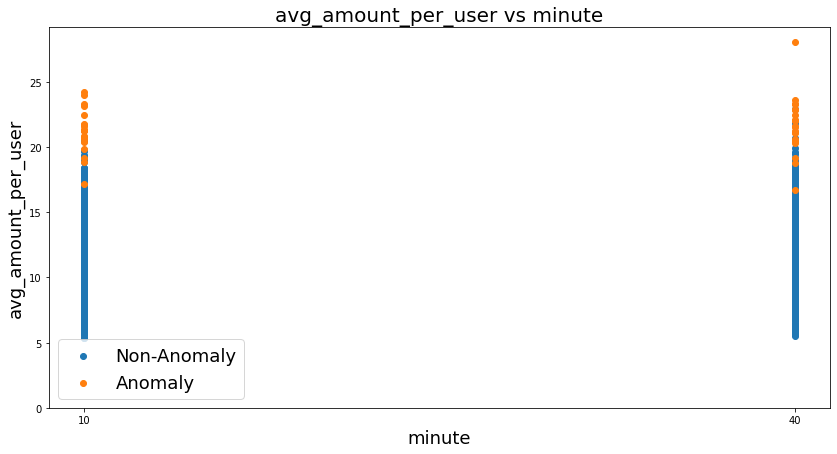

In [ ]:
# Look for seasonality by month, day, day of week, hour, minute
datetime_components = ['year', 'month', 'day', 'day_of_week', 'hour', 'minute']

for component in datetime_components:
    for metric in original_metrics:
        plot_relationship(component, metric, normal.sort_values(by=[component]), anomaly.sort_values(by=[component]))

In [ ]:
# Generates accuracy, precision, recall, f1, and confusion matrix for a model's prediction

def generate_results(y_test, predictions, model_type):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print(f'{model_type} results:')
    print(f'\tAccuracy: {accuracy}\n\tPrecision: {precision}\n\tRecall: {recall}\n\tF1: {f1}')

    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    print('Confusion Matrix:')
    print(f'{confusion_matrix}\n\n')

In [ ]:
# Rune PRESECRIPTIVE model based on given data -- should not be used for future predictions

# Maps day of week to a number so that it can be used as a predictive value in model
day_of_week_map = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}

x = data[['year', 'month', 'day', 'hour', 'minute', 'day_of_week','avg_amount_per_user', 'sum_amount', 'sum_to_avg_ratio']]
y = data['anomaly']

# Map all days of week to number values
for index in x.index:
    x.at[index, 'day_of_week'] = day_of_week_map[x.at[index, 'day_of_week']]

# Change all columns to numeric
x['year'] = pd.to_numeric(x['year'])
x['month'] = pd.to_numeric(x['month'])
x['day'] = pd.to_numeric(x['day'])
x['hour'] = pd.to_numeric(x['hour'])
x['minute'] = pd.to_numeric(x['minute'])
x['day_of_week'] = pd.to_numeric(x['day_of_week'])

# Generate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=1)

# Run XGB model with default hyperparameters
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(x_train, y_train)
xgb_predictions = xgb_clf.predict(x_test)
generate_results(y_test, xgb_predictions, 'XGBOOST')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

XGBOOST results:
	Accuracy: 0.9989139288623404
	Precision: 0.7857142857142857
	Recall: 0.9166666666666666
	F1: 0.8461538461538461
Confusion Matrix:
[[3668    3]
 [   1   11]]




In [ ]:
# Generate rolling averages for all metrics over last n reports

# Set n to 336 (last week of data)
n = 336

our_metrics = ['sum_amount', 'avg_amount_per_user', 'sum_to_avg_ratio', 'sum_times_avg']
metrics_values = {'sum_amount': data.sum_amount.tolist(), 'avg_amount_per_user': data.avg_amount_per_user.tolist(), 'sum_to_avg_ratio': data.sum_to_avg_ratio.tolist(), 'sum_times_avg': data.sum_times_avg.tolist()}

averages = {}
stdevs = {}

# Initialize empty list for each metric's averages and stdevs
for metric in our_metrics:
    averages[metric] = []
    stdevs[metric] = []

# For values that don't have n rows before them, make the average the current value and the stdev 1
for i in range(0, n):
    for metric in our_metrics:
        averages[metric].append(metrics_values[metric][i])
        stdevs[metric].append(1)

# For valuess that have at least n rows before them, take the rolling average and stdev of that range 
for i in range(n, len(data)):
    for metric in our_metrics:
        cur_avg = np.average(metrics_values[metric][i-n:i-1])
        cur_stdev = np.std(metrics_values[metric][i-n:i-1])

        averages[metric].append(cur_avg)
        stdevs[metric].append(cur_stdev)

# Make df columns out of lists
data['RA_sum_amount'] = averages['sum_amount']
data['RA_avg_amount_per_user'] = averages['avg_amount_per_user']
data['RA_sum_to_avg_ratio'] = averages['sum_to_avg_ratio']
data['RA_sum_times_avg'] = averages['sum_times_avg']

data['RS_sum_amount'] = stdevs['sum_amount']
data['RS_avg_amount_per_user'] = stdevs['avg_amount_per_user']
data['RS_sum_to_avg_ratio'] = stdevs['sum_to_avg_ratio']
data['RS_sum_times_avg'] = stdevs['sum_times_avg']

In [ ]:
# Create averages and stdevs for all metrics in given month, day of month, day of week, and hour to account for seasonality

our_metrics = ['sum_amount', 'avg_amount_per_user', 'sum_to_avg_ratio', 'sum_times_avg']

month_averages = {}
month_stdevs = {}

day_of_month_averages = {}
day_of_month_stdevs = {}

day_of_week_averages = {}
day_of_week_stdevs = {}

hour_averages = {}
hour_stdevs = {}

# Fill all averages and stdevs with empty lists
for metric in our_metrics:
    month_averages[metric] = []
    month_stdevs[metric] = []

    day_of_month_averages[metric] = []
    day_of_month_stdevs[metric] = []

    day_of_week_averages[metric] = []
    day_of_week_stdevs[metric] = []

    hour_averages[metric] = []
    hour_stdevs[metric] = []

# Iterate through all rows in data and add past values for given month, day, day of week, and hour as avg and stdev
for row in data.index:
    month = data.at[row, 'month']
    day_of_month = data.at[row, 'day']
    day_of_week = data.at[row, 'day_of_week']
    hour = data.at[row, 'hour']

    past_data = data[:row]

    month_data = past_data[past_data['month'] == month]
    day_of_month_data = past_data[past_data['day'] == day_of_month]
    day_of_week_data = past_data[past_data['day_of_week'] == day_of_week]
    hour_data = past_data[past_data['hour'] == hour]

    # Find average and stdev for all metrics
    for metric in our_metrics:

        if len(month_data) > 0:
            month_averages[metric].append(month_data[metric].mean())
            if len(month_data) > 1:
                month_stdevs[metric].append(month_data[metric].std())
            else:
                month_stdevs[metric].append(1)
        else:
            month_averages[metric].append(data.at[index, metric])
            month_stdevs[metric].append(1)

        if len(day_of_month_data) > 0:
            day_of_month_averages[metric].append(day_of_month_data[metric].mean())
            if len(day_of_month_data) > 1:
                day_of_month_stdevs[metric].append(day_of_month_data[metric].std())
            else:
                day_of_month_stdevs[metric].append(1)
        else:
            day_of_month_averages[metric].append(data.at[index, metric])
            day_of_month_stdevs[metric].append(1)

        if len(day_of_week_data) > 0:
            day_of_week_averages[metric].append(day_of_week_data[metric].mean())
            if len(day_of_week_data) > 1:
                day_of_week_stdevs[metric].append(day_of_week_data[metric].std())
            else:
                day_of_week_stdevs[metric].append(1)
        else:
            day_of_week_averages[metric].append(data.at[index, metric])
            day_of_week_stdevs[metric].append(1)

        if len(hour_data) > 0:
            hour_averages[metric].append(hour_data[metric].mean())
            if len(hour_data) > 1:
                hour_stdevs[metric].append(hour_data[metric].std())
            else:
                hour_stdevs[metric].append(1)
        else:
            hour_averages[metric].append(data.at[index, metric])
            hour_stdevs[metric].append(1)

# Turn all lists into df columns
data['AVG_sum_amount_MONTH'] = month_averages['sum_amount']
data['AVG_sum_amount_DOM'] = day_of_month_averages['sum_amount']
data['AVG_sum_amount_DOW'] = day_of_week_averages['sum_amount']
data['AVG_sum_amount_HOUR'] = hour_averages['sum_amount']

data['AVG_avg_amount_per_user_MONTH'] = month_averages['avg_amount_per_user']
data['AVG_avg_amount_per_user_DOM'] = day_of_month_averages['avg_amount_per_user']
data['AVG_avg_amount_per_user_DOW'] = day_of_week_averages['avg_amount_per_user']
data['AVG_avg_amount_per_user_HOUR'] = hour_averages['avg_amount_per_user']

data['AVG_sum_to_avg_ratio_MONTH'] = month_averages['sum_to_avg_ratio']
data['AVG_sum_to_avg_ratio_DOM'] = day_of_month_averages['sum_to_avg_ratio']
data['AVG_sum_to_avg_ratio_DOW'] = day_of_week_averages['sum_to_avg_ratio']
data['AVG_sum_to_avg_ratio_HOUR'] = hour_averages['sum_to_avg_ratio']

data['AVG_sum_times_avg_MONTH'] = month_averages['sum_times_avg']
data['AVG_sum_times_avg_DOM'] = day_of_month_averages['sum_times_avg']
data['AVG_sum_times_avg_DOW'] = day_of_week_averages['sum_times_avg']
data['AVG_sum_times_avg_HOUR'] = hour_averages['sum_times_avg']

data['STD_sum_amount_MONTH'] = month_stdevs['sum_amount']
data['STD_sum_amount_DOM'] = day_of_month_stdevs['sum_amount']
data['STD_sum_amount_DOW'] = day_of_week_stdevs['sum_amount']
data['STD_sum_amount_HOUR'] = hour_stdevs['sum_amount']

data['STD_avg_amount_per_user_MONTH'] = month_stdevs['avg_amount_per_user']
data['STD_avg_amount_per_user_DOM'] = day_of_month_stdevs['avg_amount_per_user']
data['STD_avg_amount_per_user_DOW'] = day_of_week_stdevs['avg_amount_per_user']
data['STD_avg_amount_per_user_HOUR'] = hour_stdevs['avg_amount_per_user']

data['STD_sum_to_avg_ratio_MONTH'] = month_stdevs['sum_to_avg_ratio']
data['STD_sum_to_avg_ratio_DOM'] = day_of_month_stdevs['sum_to_avg_ratio']
data['STD_sum_to_avg_ratio_DOW'] = day_of_week_stdevs['sum_to_avg_ratio']
data['STD_sum_to_avg_ratio_HOUR'] = hour_stdevs['sum_to_avg_ratio']

data['STD_sum_times_avg_MONTH'] = month_stdevs['sum_times_avg']
data['STD_sum_times_avg_DOM'] = day_of_month_stdevs['sum_times_avg']
data['STD_sum_times_avg_DOW'] = day_of_week_stdevs['sum_times_avg']
data['STD_sum_times_avg_HOUR'] = hour_stdevs['sum_times_avg']

In [ ]:
# Filter data to the columns that will be used to predict, and the target label (anomaly)

data = data[['sum_amount', 'avg_amount_per_user', 'sum_to_avg_ratio', 'sum_times_avg', 
            'RA_sum_amount', 'RA_avg_amount_per_user', 'RA_sum_to_avg_ratio', 
            'RS_sum_amount', 'RS_avg_amount_per_user', 'RS_sum_to_avg_ratio',
            'AVG_sum_amount_MONTH', 'AVG_sum_amount_DOM', 'AVG_sum_amount_DOW', 'AVG_sum_amount_HOUR', 
            'AVG_avg_amount_per_user_MONTH', 'AVG_avg_amount_per_user_DOM', 'AVG_avg_amount_per_user_DOW', 'AVG_avg_amount_per_user_HOUR', 
            'AVG_sum_to_avg_ratio_MONTH', 'AVG_sum_to_avg_ratio_DOM', 'AVG_sum_to_avg_ratio_DOW', 'AVG_sum_to_avg_ratio_HOUR',  
            'STD_sum_amount_MONTH', 'STD_sum_amount_DOM', 'STD_sum_amount_DOW', 'STD_sum_amount_HOUR',
            'STD_avg_amount_per_user_MONTH', 'STD_avg_amount_per_user_DOM', 'STD_avg_amount_per_user_DOW', 'STD_avg_amount_per_user_HOUR',
            'STD_sum_to_avg_ratio_MONTH', 'STD_sum_to_avg_ratio_DOM', 'STD_sum_to_avg_ratio_DOW', 'STD_sum_to_avg_ratio_HOUR', 
            'anomaly']]

In [ ]:
# Generate model to predict anomaly

# Split data into predictors and anomaly
x = data.drop(columns=['anomaly'])
y = data['anomaly']

# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=1)

# Create XGB Classifier and predict on testing set
xgb_clf = xgb.XGBClassifier(learning_rate=.01, subsample=0.2)
xgb_clf.fit(x_train, y_train)
xgb_predictions = xgb_clf.predict(x_test)

train_predictions = xgb_clf.predict(x_train)
generate_results(y_train, train_predictions, 'XGB TRAIN')
generate_results(y_test, xgb_predictions, 'XGB')

precision, recall, thresholds = precision_recall_curve(y_test, xgb_predictions)

## WITH SMOTE

# Generate synthetic data points to help with significant underbalance in anomalies
oversample = SMOTE(random_state = 1, sampling_strategy=.1)
x, y = oversample.fit_resample(x, y)

# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=1)

# Create XGB Classifier and predict on testing set
xgb_clf = xgb.XGBClassifier(learning_rate=.01, subsample=0.2)
xgb_clf.fit(x_train, y_train)
xgb_predictions = xgb_clf.predict(x_test)

train_predictions = xgb_clf.predict(x_train)
generate_results(y_train, train_predictions, 'XGB TRAIN with SMOTE')
generate_results(y_test, xgb_predictions, 'XGB with SMOTE')

precision, recall, thresholds = precision_recall_curve(y_test, xgb_predictions)

XGB TRAIN results:
	Accuracy: 0.9988359911535327
	Precision: 0.88
	Recall: 0.7586206896551724
	F1: 0.8148148148148148
Confusion Matrix:
[[8559    3]
 [   7   22]]


XGB results:
	Accuracy: 0.9994569644311703
	Precision: 0.9166666666666666
	Recall: 0.9166666666666666
	F1: 0.9166666666666666
Confusion Matrix:
[[3670    1]
 [   1   11]]


XGB TRAIN with SMOTE results:
	Accuracy: 0.9963902749761121
	Precision: 0.9835294117647059
	Recall: 0.9766355140186916
	F1: 0.9800703399765534
Confusion Matrix:
[[8549   14]
 [  20  836]]


XGB with SMOTE results:
	Accuracy: 0.9955412434976467
	Precision: 0.9833795013850416
	Recall: 0.9673024523160763
	F1: 0.9752747252747253
Confusion Matrix:
[[3664    6]
 [  12  355]]




In [ ]:
# Write data to csv

data.to_csv('/content/drive/MyDrive/IndependentProjects/BOSS_AI_PROJECT/Prepared_Data.csv')